In [8]:
import jax.numpy as jnp
from jax import jit
from jax.experimental.ode import odeint
import numpy as np
import matplotlib.pyplot as plt

`3.1` Lagrange Basis: <br>
$$\ell_i(x) = \prod_{\substack{j=0 \\ j \ne i}}^{n-1} \frac{x - x_j}{x_i - x_j} \quad (0 \le i < n)$$

In [3]:
x = jnp.array(5, ndmin=1)

In [4]:
len(x)

1

In [5]:
# @jit
def lagrange_basis(xi, x):
    n = len(xi)
    L = jnp.ones((n, len(x)))
        
    for i in range(n):
        for j in range(n):
            if i != j:
                L = L.at[i, :].set(L[i, :] * (x - xi[j]) / (xi[i] - xi[j]))
    return L

In [6]:
def lagrange_basis_single(xi, x, j):
    """
    Compute the j-th Lagrange basis polynomial at a single point x.

    Parameters:
    xi (array_like): The nodes at which the Lagrange polynomials are defined.
    j (int): Index of the polynomial to compute.
    x (float): The point at which to evaluate the polynomial.

    Returns:
    float: The value of the j-th Lagrange basis polynomial at x.
    """
    n = len(xi)
    L = 1.0
    for m in range(n):
        if m != j:
            L *= (x - xi[m]) / (xi[j] - xi[m])
        # L *= jnp.where(m != j, (x - xi[m]) / (xi[j] - xi[m]), 1.0)
    return L

`3.2` First Derivative:<br>
$$\ell_j'(x_i) = \frac{w_j / w_i}{x_i - x_j}$$
where: <br>
$$w_j = \frac{1}{\ell'(x_j)} = \frac{1}{\prod_{k=1, k \ne j}^n (x_j - x_k)}, \quad j = 1, \ldots, n.$$

In [7]:
def derivative_at_node(xi, j, h=1e-5):
    """Approximate the derivative of the j-th Lagrange basis polynomial at its node x_j using central differences."""
    x_j = xi[j]
    forward = lagrange_basis_single(xi, x_j + h, j)
    backward = lagrange_basis_single(xi, x_j - h, j)
    derivative = (forward - backward) / (2 * h)
    return derivative

In [8]:
# @jit
def compute_weights(xi):
    """
    Compute the weights for each node in the array of nodes xi used in Lagrange interpolation.

    Parameters:
    xi (array_like): The nodes at which the weights are to be computed.

    Returns:
    array_like: An array of weights corresponding to each node.
    """
    n = len(xi)
    xi = jnp.array(xi) 
    weights = jnp.zeros(n)

    for j in range(n):
        # Exclude the j-th term and compute the product of (x_j - x_m) for all m != j
        terms = xi[j] - jnp.delete(xi, j)
        product = jnp.prod(terms)
        weights = weights.at[j].set(1.0 / product)

    return weights

# @jit
def lagrange_derivative(xi, weights):
    n = len(xi)
    D = jnp.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                D = D.at[i, j].set(weights[j] / weights[i] / (xi[i] - xi[j]))
            else:
                # approximation to handle the diagonal case; it needs proper handling for exact values!!!
                # D = D.at[i, j].set(0)
                approx_derivative = derivative_at_node(xi, j)
                D = D.at[i, j].set(approx_derivative)
    return D


In [9]:
# Example nodes and calculation
xi = jnp.linspace(-1, 1, 5)  # 5 nodes evenly spaced
weights = compute_weights(xi)
x = jnp.linspace(-1, 1, 100)  # Points to evaluate the basis
basis = lagrange_basis(xi, x)
derivatives = lagrange_derivative(xi, weights)

In [10]:
print(basis.shape)
print(derivatives.shape)

(5, 100)
(5, 5)


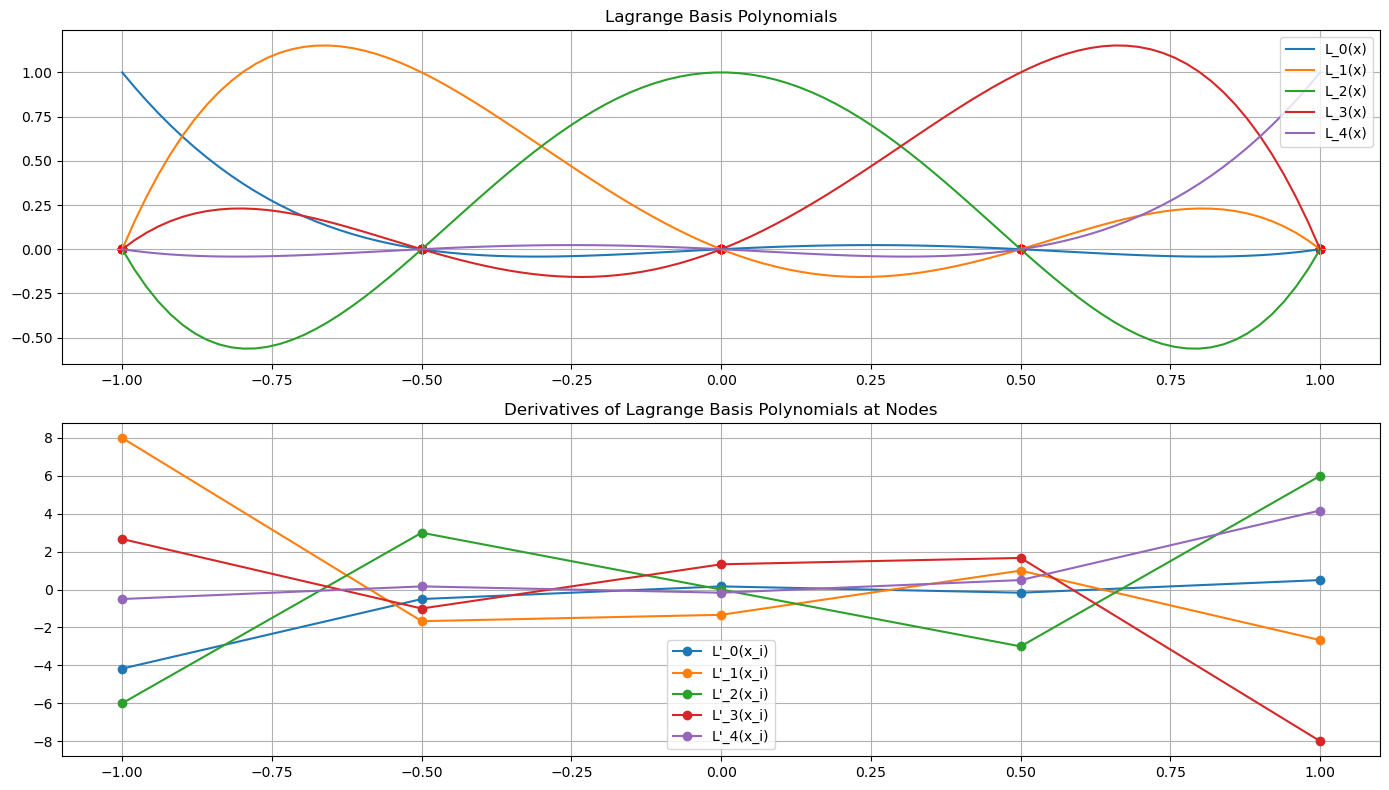

In [11]:
plt.figure(figsize=(14, 8))
for i in range(len(xi)):
    plt.subplot(2, 1, 1)
    plt.plot(x, basis[i, :], label=f'L_{i}(x)')
    plt.scatter(xi, jnp.zeros_like(xi), color='red')  # Nodes
    plt.title('Lagrange Basis Polynomials')
    plt.grid()
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(xi, derivatives[:, i], label=f'L\'_{i}(x_i)', marker='o')
    plt.title('Derivatives of Lagrange Basis Polynomials at Nodes')
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()

In [12]:
from interpolation import *

In [13]:
n = 24
a, b = 0, 10
poly = BarycentricInterpolation(n=n, kind='chebyshev2', start=a, stop=b)
xi = poly.nodes

In [14]:
# test
basis = lagrange_basis(xi, xi)
weights = compute_weights(xi)
derivatives = lagrange_derivative(xi, weights)

(derivatives*3 + basis).shape

(24, 24)

In [16]:
derivatives[0]

Array([-35.3       ,  42.94584   , -10.786695  ,   4.831578  ,
        -2.7476196 ,   1.7834162 ,  -1.2600533 ,   0.94491214,
        -0.7408296 ,   0.6013949 ,  -0.50216955,   0.42929602,
        -0.37444675,   0.33237612,  -0.29965246,   0.2739605 ,
        -0.25369775,   0.2377339 ,  -0.2252617 ,   0.21570036,
        -0.20863558,   0.20377769,  -0.20093647,   0.10000101],      dtype=float32)

In [60]:
display(basis[0])

Array([ 1., -0.,  0., -0.,  0., -0.,  0., -0.,  0., -0.,  0., -0.,  0.,
       -0.,  0., -0.,  0., -0.,  0., -0.,  0., -0.,  0., -0.],      dtype=float32)

In [61]:
basis[1]

Array([ 0.,  1., -0.,  0., -0.,  0., -0.,  0., -0.,  0., -0.,  0., -0.,
        0., -0.,  0., -0.,  0., -0.,  0., -0.,  0., -0.,  0.],      dtype=float32)

In [62]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [87]:
derivatives[1]

Array([-10.736467  ,   5.343115  ,   7.202365  ,  -2.7220287 ,
         1.4677126 ,  -0.93034273,   0.649071  ,  -0.4830853 ,
         0.3769169 ,  -0.30496818,   0.25405556,  -0.21681543,
         0.1888702 ,  -0.16748436,   0.15087904,  -0.13785973,
         0.12760271,  -0.11952866,   0.11322477,  -0.10839464,
         0.1048271 ,  -0.10237464,   0.10094056,  -0.05023447],      dtype=float32)

In [63]:
def construct_matrix_and_vector(xi, y0):
    """
    Construct the matrix A and vector b for solving an ODE using Lagrange basis polynomials,
    incorporating an initial value condition.

    Parameters:
    xi (array_like): Nodes at which the values of the ODE solution are known or to be calculated.
    y0 (float): The initial value at the first node xi[0].

    Returns:
    tuple: A tuple containing the matrix A and vector b for the ODE problem.
    """
    n = len(xi)
    b = jnp.zeros(n)
    
    # basis = lagrange_basis(xi, xi)
    # basis is just the identity matrix!
    basis = jnp.eye(n)
    weights = compute_weights(xi)
    derivatives = lagrange_derivative(xi, weights)
    
    # specific ODE definition
    A = derivatives + 3*basis
    
    # initial condition
    A = A.at[0, :].set(0)  
    A = A.at[0, 0].set(1) 
    # Set the initial condition 
    # 1y0 + 0y1 + 0y2 + ... = y0
    b = b.at[0].set(y0)


    for i in range(1, n): 
        # RHS of the differential equation evaluated at nodes
        b = b.at[i].set(2 * jnp.exp(-xi[i]) * jnp.sin(xi[i]) + jnp.exp(-xi[i]) * jnp.cos(xi[i]))
    
    return A, b

In [64]:
n = 32
a, b = 0, 10
poly = BarycentricInterpolation(n=n, kind='chebyshev2', start=a, stop=b)
xi = poly.nodes

In [65]:
%%time
A, b = construct_matrix_and_vector(xi, 0)

CPU times: user 300 ms, sys: 6.94 ms, total: 307 ms
Wall time: 306 ms


In [66]:
from jax.scipy.linalg import solve

def find_solution(A, b):
    """
    Solve the linear system of equations A * y = b for y.
    """
    # Solve the linear system
    y = solve(A, b)
    return y

In [67]:
y_coeff = find_solution(A, b)
print("Solution coefficients y:", y_coeff)

Solution coefficients y: [ 1.3608644e-07  2.5001034e-02  9.2231885e-02  1.8072300e-01
  2.6287523e-01  3.1357023e-01  3.1872419e-01  2.7965519e-01
  2.1112868e-01  1.3411894e-01  6.7155838e-02  2.0523936e-02
 -4.6510706e-03 -1.3422519e-02 -1.2811715e-02 -8.6746905e-03
 -4.4839489e-03 -1.5867607e-03 -5.7563928e-05  5.1976158e-04
  5.9226289e-04  4.6808360e-04  3.0904709e-04  1.7855685e-04
  8.9478446e-05  3.5095152e-05  4.5108454e-06 -1.1521767e-05
 -1.9362453e-05 -2.2906715e-05 -2.4330617e-05 -2.4699992e-05]


In [68]:
def solution(t):
    return jnp.exp(-t) * jnp.sin(t)

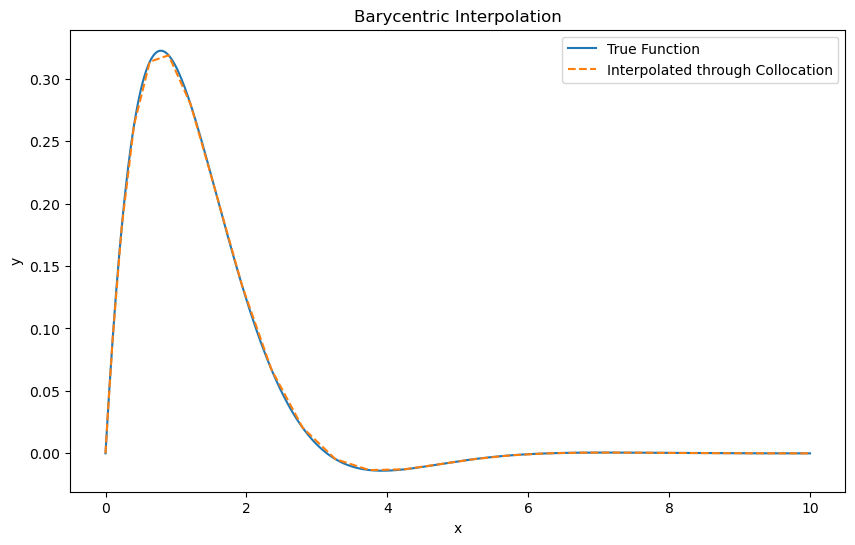

In [79]:
poly = BarycentricInterpolation(n=n, kind='chebyshev2', start=a, stop=b)

x_plot = np.linspace(0, 10, 400)
# interpolate based on 24 nodese
interpolated_y = np.array([poly.interpolate(y_coeff, xi) for xi in x_plot]) 

plt.figure(figsize=(10, 6))
plt.plot(x_plot, solution(x_plot), label='True Function')
plt.plot(xi, y_coeff, '--', label='Interpolated through Collocation')
plt.title('Barycentric Interpolation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [80]:
def rk4_step(f, y, t, dt, *args, **kwargs):
    """
    Perform a single step of the RK4 integration.

    Parameters:
    - f: The derivative function of the system, should accept at least two parameters (y, t) and additional parameters
    - y: Current value of the dependent variable
    - t: Current time
    - dt: Step size
    - args, kwargs: Additional arguments and keyword arguments for the derivative function f

    Returns:
    - y_next: Next value of y after a step dt
    """
    k1 = dt * f(y, t, *args, **kwargs)
    k2 = dt * f(y + 0.5 * k1, t + 0.5 * dt, *args, **kwargs)
    k3 = dt * f(y + 0.5 * k2, t + 0.5 * dt, *args, **kwargs)
    k4 = dt * f(y + k3, t + dt, *args, **kwargs)
    y_next = y + (k1 + 2*k2 + 2*k3 + k4) / 6
    return y_next

In [84]:
def derivative(y, t):
    """
    Defines the derivative of y for the differential equation y' + 3y = 2e^{-t} sin(t) + e^{-t} cos(t).
    Rearrange to: y' = -3y + 2e^{-t} sin(t) + e^{-t} cos(t).
    """
    return -3*y + 2*np.exp(-t)*np.sin(t) + np.exp(-t)*np.cos(t)

# Initial conditions and time step setup
y0 = 0  # Initial value of y
t0 = 0  # Start time
tf = 10  # End time
dt = 0.1  # Time step
steps = int((tf - t0) / dt) 
print(steps)
times = np.linspace(t0, tf, steps)
values = np.zeros(steps)

# Setting initial condition
y = y0

100


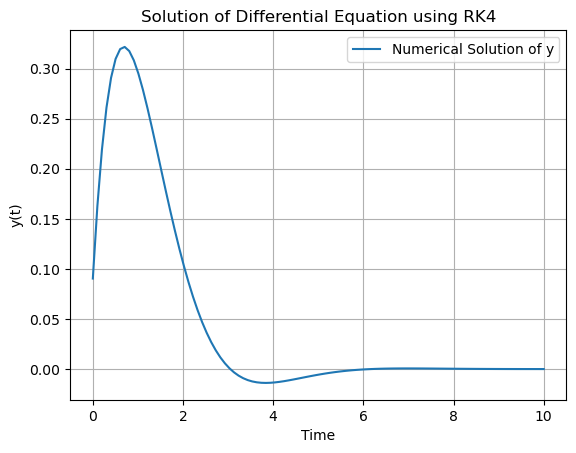

CPU times: user 176 ms, sys: 5.8 ms, total: 182 ms
Wall time: 67.3 ms


In [85]:
%%time 
# Perform RK4 integration
for i in range(steps):
    y = rk4_step(derivative, y, times[i], dt)
    values[i] = y

# Plotting the results
plt.plot(times, values, label='Numerical Solution of y')
plt.title('Solution of Differential Equation using RK4')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
from solvers import *
import jax.numpy as jnp

In [37]:
def derivative(y, t):
    """
    Defines the derivative of y for the differential equation y' + 3y = 2e^{-t} sin(t) + e^{-t} cos(t).
    Rearrange to: y' = -3y + 2e^{-t} sin(t) + e^{-t} cos(t).
    """
    return -3*y + 2*jnp.exp(-t)*jnp.sin(t) + jnp.exp(-t)*jnp.cos(t)

# Define initial conditions and time interval
y0 = 0
t0 = 0
t_range = 10
steps = 1000

# Solve the ODE
times, values = rk4_solver(derivative, y0, t0, t_range, t_range/steps)

In [39]:
times

[0,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.060000000000000005,
 0.07,
 0.08,
 0.09,
 0.09999999999999999,
 0.10999999999999999,
 0.11999999999999998,
 0.12999999999999998,
 0.13999999999999999,
 0.15,
 0.16,
 0.17,
 0.18000000000000002,
 0.19000000000000003,
 0.20000000000000004,
 0.21000000000000005,
 0.22000000000000006,
 0.23000000000000007,
 0.24000000000000007,
 0.25000000000000006,
 0.26000000000000006,
 0.2700000000000001,
 0.2800000000000001,
 0.2900000000000001,
 0.3000000000000001,
 0.3100000000000001,
 0.3200000000000001,
 0.3300000000000001,
 0.34000000000000014,
 0.35000000000000014,
 0.36000000000000015,
 0.37000000000000016,
 0.38000000000000017,
 0.3900000000000002,
 0.4000000000000002,
 0.4100000000000002,
 0.4200000000000002,
 0.4300000000000002,
 0.4400000000000002,
 0.45000000000000023,
 0.46000000000000024,
 0.47000000000000025,
 0.48000000000000026,
 0.49000000000000027,
 0.5000000000000002,
 0.5100000000000002,
 0.5200000000000002,
 0.5300000000000002,
 0.54000000

In [35]:
len(values[0:1000])

1000

In [10]:
display(odeint)

<function jax.experimental.ode.odeint(func, y0, t, *args, rtol=1.4e-08, atol=1.4e-08, mxstep=inf, hmax=inf)>

In [43]:
def derivative(y, t):
    """
    Defines the derivative of y for the differential equation y' + 3y = 2e^{-t} sin(t) + e^{-t} cos(t).
    Rearrange to: y' = -3y + 2e^{-t} sin(t) + e^{-t} cos(t).
    """
    dydt = -3 * y + 2 * jnp.exp(-t) * jnp.sin(t) + jnp.exp(-t) * jnp.cos(t)
    return dydt

y0 = jnp.array([0.0])
t = jnp.linspace(0, 10, 1002)

odeint_values = odeint(derivative, y0, t)

In [44]:
odeint_values.shape

(1002, 1)

In [45]:
odeint_values = odeint_values.ravel() 
odeint_values

Array([ 0.0000000e+00,  9.8905424e-03,  1.9583484e-02, ...,
       -2.4416920e-05, -2.4562039e-05, -2.4699328e-05], dtype=float32)

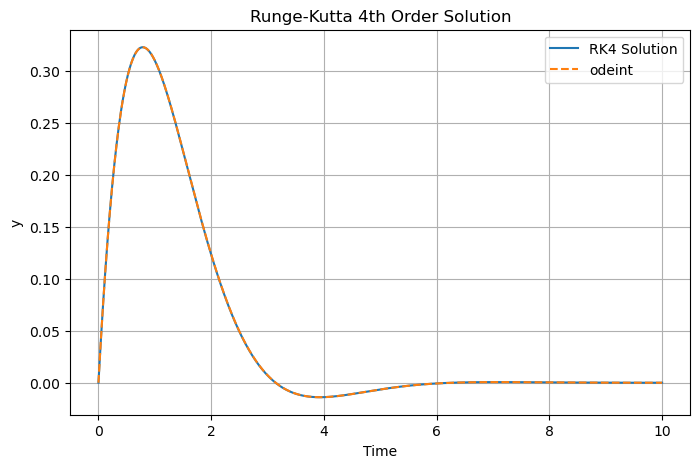

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(times, values, label='RK4 Solution')
plt.plot(times, odeint_values, '--', label='odeint')
plt.xlabel('Time')
plt.ylabel('y')
plt.title('Runge-Kutta 4th Order Solution')
plt.legend()
plt.grid(True)
plt.show()